In [1]:
#
# 2017-08-31
#
# XGB - решение - дурняк, но работает
#
#
#

In [2]:
import sys, os, math, datetime
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def dataClean( df ) :
    def cn (cc) : 
        cc = np.reshape(cc.values,(len(df)))
        return([jj for jj,dd in enumerate(cc.tolist()) if dd ])
    ##df=df.fillna(0.0)
    badly = np.zeros((len(df)),dtype=np.int32)
    ##cols  = df.columns.tolist()
    ##print(cols)
    for ii,nn in enumerate(df.columns.tolist()) :
        
        if (ii==0) and (nn.startswith('Chloro')) : # Chlorophyl
            cc = ((df[[ii]]<0.0) | (df[[ii]]>1.0))
            df.iloc[cn(cc),ii] = 0.0
            #badly[cn(cc)] += 1
        
        if (ii==1) and (nn.startswith('Depth')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==3) and (nn.startswith('Eastward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==4) and (nn.startswith('Latitude')) :
            cc = (df[[ii]]< -90.0);      df.iloc[cn(cc),ii] = -90.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  90.0);      df.iloc[cn(cc),ii] =  90.0; badly[cn(cc)] += 1
        
        if (ii==5) and (nn.startswith('Longitude')) :
            cc = (df[[ii]]< -180.0);      df.iloc[cn(cc),ii] = -180.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  180.0);      df.iloc[cn(cc),ii] =  180.0; badly[cn(cc)] += 1
        
        if (ii==6) and (nn.startswith('Northward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==7) and (nn.startswith('Oceanic')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==8) and (nn.startswith('SOG')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==9) and (nn.startswith('Salinity')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==10) and (nn.startswith('Sea')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==11) and (nn.startswith('Speed')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1

        if (ii==11) and (nn.startswith('Thermocline')) : 
            cc = (df[[ii]]<     0.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

        if (ii==15) and (nn.startswith('Water')) : 
            cc = (df[[ii]]<  -100.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

    print(cc.sum(),badly.sum())
    return(badly)

In [4]:
# Читаем train список
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [5]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [6]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [7]:
# Читаем test список
test_list = pd.read_csv('../Data/testing.txt', header=None)
test_list.columns=['trackfile']
print 'test length:',len(test_list)
test_list.head()

test length: 1211


,trackfile
0,100015
1,100045
2,100060
3,100112
4,100131


In [479]:
# Построение массива с данными по списку файлов

def buildX (file_list, nFiles=-1, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
        havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)

        cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)

        hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
        dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)

        maxSpeed    = 35.0
        
        xx['Distance'] = dist
        xx['Speed']    = np.round((dist/1.852/xx.hTime).fillna(0.0),2)
        xx.loc[xx.Speed>maxSpeed,'Speed'] = maxSpeed
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [482]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=12);
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
print datetime.datetime.now()
##len(trainAll_.TrackNumber.unique()),trainAll_.TrackNumber.unique(),trainAll_.tail()

2017-09-04 00:40:33.673310
	Latitudes: between -67.458415 and 56.720937 
	Longitudes: between -179.67688 and 179.980242 
	Files=12 Shapes=(68343, 18)
2017-09-04 00:40:33.908636


In [458]:
trainAll_.describe()

,TrackNumber,Time(seconds),Latitude,Longitude,SOG,oceanic depth,Chlorophyll Concentration,Salinity,Water Surface Elevation,Sea Temperature,Thermocline Depth,Eastward Water Velocity,Northward Water Velocity,Time,sTime,hTime,Distance,Speed
count,514629.000000,5.146290e+05,514629.000000,514629.000000,514629.000000,514629.000000,514629.000000,514629.000000,514629.000000,514629.000000,514629.000000,514629.000000,514629.000000,5.146290e+05,5.146290e+05,514629.000000,514629.000000,514629.000000
mean,101054.418978,3.803839e+06,32.366352,-19.679915,-3.244157,-246.308523,-39263.178204,-6581.683269,-6614.097143,-6602.653360,-6631.261112,-6613.634928,-6613.706682,3.803839e+06,1.413939e+03,0.510658,1.511362,3.246236
std,5933.797611,2.334740e+06,26.294621,100.118406,836.390887,439.063844,48834.098397,24860.804568,24852.178468,24855.225915,25215.646473,24852.301463,24852.282367,2.334740e+06,2.501813e+04,7.233002,15.067418,5.057162
min,35.000000,0.000000e+00,-56.127833,-179.998095,-99999.000000,-2241.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,100481.000000,1.671223e+06,13.561688,-122.378663,0.000000,-203.000000,-99999.000000,34.000000,-1.320000,1.700000,100.800000,-0.120000,-0.140000,1.671223e+06,3.100000e+01,0.008611,0.001456,0.010000
50%,101353.000000,3.887371e+06,43.316143,-2.004728,1.000000,-22.000000,0.102000,34.200000,-0.330000,8.900000,147.800000,0.070000,-0.010000,3.887371e+06,3.520000e+02,0.099167,0.008757,0.120000
75%,102216.000000,5.832785e+06,53.857548,14.426485,7.300000,-1.000000,0.316800,34.800000,0.010000,16.800000,200.400000,0.220000,0.100000,5.832785e+06,9.280000e+02,0.258056,0.453752,4.640000
max,102638.000000,7.948603e+06,62.324478,179.994255,102.200000,173.000000,70.928800,37.700000,35.000000,35.000000,2391.600000,35.000000,35.000000,7.948603e+06,4.293745e+06,1192.706944,3614.233011,35.000000


In [459]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist());
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
trainAll  = trainAll_
trainAll.to_csv('../Data/trainingAllNew.csv',index=False)
del trainAll_
print datetime.datetime.now()

2017-09-04 00:22:04.638465
	Latitudes: between -56.218778 and 77.852447 
	Longitudes: between -179.999883 and 179.999953 
	Files=1210 Shapes=(8069012, 19)
2017-09-04 00:30:50.123312


In [460]:
len(train_list['trackfile'].values.tolist())

1209

In [8]:
trainAll = pd.read_csv('../Data/trainingAllNew.csv')

In [9]:
#trainWeights = dataClean(trainAll)

In [10]:
!ls -la ../Data
trainAll.shape

total 2118448
drwxrwxrwx 1 boba boba       4096 сен  1 15:28 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(8080623, 20)

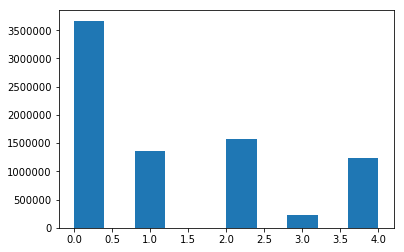

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
0,100047,0.3105,-4,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,...,10.7,6.652769,111.0,0,0,-0.22,0.258611,-4.0,931.0,0
1,100047,0.3043,-11,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,...,10.7,9.012747,109.5,931,931,-0.22,0.358333,-11.0,1290.0,0
2,100047,0.3059,-16,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,...,10.7,10.337037,117.4,2221,2221,-0.23,0.458611,-16.0,1651.0,0
3,100047,0.3674,-46,0.000000,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.000000,123.8,3872,3872,-0.24,0.000278,-46.0,1.0,0
4,100047,0.3674,-46,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.046135,123.8,3873,3873,-0.24,0.001111,-46.0,4.0,0


In [414]:
trainIndex = buildY(train_list,y_class)
train      = trainAll.set_index('TrackNumber')
train['y'] = trainIndex.set_index('trackfile').y
train      = train.reset_index()
plt.hist(train.y); plt.show(); plt.close()
train.head()

In [215]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [13]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
train_x = train.drop(['y','TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
train_y = train.y.values  #[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

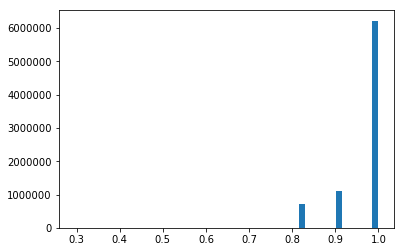

(0.29411764705882354, 1.0, (8080623, 17), 0, 8)

In [37]:
# Добавляем веса, чтобы не удалять записи из массива
temp = (0.0+train_x.shape[1]-1.5*trainWeights)/train_x.shape[1]
mtrain.set_weight(temp)
trainWeights.min(), trainWeights.max()
plt.hist(temp,bins=50); plt.show()
temp.min(),temp.max(), train_x.shape, trainWeights.min(), trainWeights.max()

In [15]:
train_y.shape, train_x.shape, train_x.columns.tolist(), train_y.max()

((8080623,),
 (8080623, 17),
 ['Chlorophyll Concentration',
  'Depth',
  'Distance',
  'Eastward Water Velocity',
  'Latitude',
  'Longitude',
  'Northward Water Velocity',
  'Oceanic Depth',
  'SOG',
  'Salinity',
  'Sea Temperature',
  'Speed',
  'Thermocline Depth',
  'Water Surface Elevation',
  'hTime',
  'oceanic depth',
  'sTime'],
 4)

In [16]:
##import sklearn as sk
##from sklearn.model_selection import cross_val_score

In [17]:
##cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

In [18]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
parms = {'num_class':5,'metrics':'mlogloss'}
parms['objective'] = 'multi:softprob'
parms['eval_metric'] = ['merror','mlogloss']
parms['silent'] = 0

evallist  = [(mtrain,'train')]
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

##hist = xgb.cv(parms,mtrain,num_boost_round=30,nfold=5,early_stopping_rounds=4,verbose_eval=True,metrics='mlogloss')
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

In [55]:
#xgbmodel = xgb.train(parms,mtrain,num_boost_round=1) # empty nodel

In [120]:
print datetime.datetime.now()
xgbmodel = xgb.train(parms,mtrain,num_boost_round=200, evals=evallist, xgb_model=xgbmodel) # = 400
print datetime.datetime.now()

2017-09-03 02:18:00.947194
[0]	train-merror:0.034516	train-mlogloss:0.109278
[1]	train-merror:0.034403	train-mlogloss:0.108899
[2]	train-merror:0.034277	train-mlogloss:0.108498
[3]	train-merror:0.034066	train-mlogloss:0.108099
[4]	train-merror:0.033936	train-mlogloss:0.107671
[5]	train-merror:0.033822	train-mlogloss:0.107395
[6]	train-merror:0.033675	train-mlogloss:0.107043
[7]	train-merror:0.033548	train-mlogloss:0.106703
[8]	train-merror:0.033427	train-mlogloss:0.106352
[9]	train-merror:0.033306	train-mlogloss:0.106023
[10]	train-merror:0.033154	train-mlogloss:0.105631
[11]	train-merror:0.03306	train-mlogloss:0.105383
[12]	train-merror:0.032901	train-mlogloss:0.105021
[13]	train-merror:0.032756	train-mlogloss:0.104644
[14]	train-merror:0.03258	train-mlogloss:0.104258
[15]	train-merror:0.032414	train-mlogloss:0.103945
[16]	train-merror:0.032271	train-mlogloss:0.103551
[17]	train-merror:0.032181	train-mlogloss:0.103283
[18]	train-merror:0.032076	train-mlogloss:0.103012
[19]	train-merro

In [21]:
#xgbmodel.load_model('../Work/xgbModel.bst')
##xgbmodel.load_model('../Work/xgbModelClean.bst')
##xgbmodel.save_model('../Work/xgbModelCleanSoftProb.bst')
##xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-200.bst')
#xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
xgbmodel = xgb.Booster()
xgbmodel.load_model('../Work/xgbModel-NotClean-SoftProb-400.bst')

In [187]:
pred_y = xgbmodel.predict(mtrain); ##pred_y[-20:],pred_y.max()

In [23]:
pred_y.shape, pred_y.max() #pred_y[:4]

((8080623, 5), 1.0)

In [24]:
pred_y_softmax=pred_y.argmax(axis=1); pred_y_softmax.shape

(8080623,)

In [25]:
((pred_y_softmax==train_y).sum()/float(len(pred_y)))

0.98035337126852717

In [26]:
df_diff = pd.DataFrame(train.TrackNumber,columns=['TrackNumber'])
df_diff['true_y'] = np.array(train_y,dtype=np.uint8)
df_diff['pred_y'] = np.array(pred_y_softmax, dtype=np.uint8)

df_diff['OK']    = df_diff.true_y==df_diff.pred_y

#print(df_diff.head())

len(df_diff)-df_diff.OK.sum()
aa = df_diff.groupby(['TrackNumber','OK']).size().reset_index(); aa.columns=['TrackNumber','OK','ccount']; aa.head()
bb = pd.DataFrame(train.TrackNumber.unique(),columns=['TrackNumber'])
bb['xx'] = 1.0; bb=bb.set_index(['TrackNumber'])
cc = aa[['TrackNumber','ccount']][aa.OK==True];  cc.head(); cc = cc.set_index(['TrackNumber']); bb['Yes']=cc
cc = aa[['TrackNumber','ccount']][aa.OK==False]; cc.head(); cc = cc.set_index('TrackNumber'); bb['No'] =cc
bb=bb.reset_index().drop('xx',axis=1).fillna(0)
print(bb.head())
float(len(bb[bb.No>bb.Yes]))/len(bb)*100.0

   TrackNumber      Yes    No
0       100047    669.0   0.0
1       100070    338.0  70.0
2       100080  12161.0   5.0
3       100093   6080.0  43.0
4       100144  15478.0   0.0


0.9925558312655087

In [188]:
#trainAll.describe()

In [189]:
#testAll.describe()

In [73]:
##xgbmodel.save_model('../Work/xgbModel.bst')

In [27]:
fimp  = xgbmodel.get_fscore();
ffimp = [[k,fimp[k]] for k in fimp.keys()]; 
ffimp.sort(key=lambda x: x[1],reverse=True)
tempsum = 0
for temp in ffimp : tempsum+=temp[1];
##print(tempsum)
for ii,temp in enumerate(ffimp) : 
    ffimp[ii][1] = float(ffimp[ii][1])/tempsum*100.0;
ffimp

[['Longitude', 12.749085514030645],
 ['Latitude', 11.819677862191867],
 ['SOG', 9.153386369256218],
 ['Oceanic Depth', 7.9937584733839815],
 ['Eastward Water Velocity', 7.1257428866207935],
 ['Water Surface Elevation', 6.813666555819882],
 ['Northward Water Velocity', 6.568098295517527],
 ['Sea Temperature', 6.5203489115698465],
 ['Chlorophyll Concentration', 6.202303907775476],
 ['Thermocline Depth', 5.850152201161333],
 ['Salinity', 5.039265341621262],
 ['Depth', 4.976167941404685],
 ['Speed', 2.650943476666752],
 ['Distance', 2.4642092787285024],
 ['hTime', 2.4028172136529133],
 ['oceanic depth', 1.6703757705983167]]

In [28]:
y_class, trainIndex['typing'][132759]

(['trawler', 'longliner', 'seiner', 'other', 'support'], 'seiner')

In [359]:
hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [358]:
if 0 :
    train_o          = train.copy()
    pred_y_o         = pred_y.copy()
    pred_y_softmax_o = pred_y_softmax.copy()
if 1 :
    train            = train_o.copy()
    pred_y           = pred_y_o.copy()
    pred_y_softmax   = pred_y_softmax_o.copy()
len(train), len(pred_y), len(pred_y_softmax)

(8080623, 8080623, 8080623)

In [360]:
train          = train[OKtrain]
pred_y         = pred_y[OKtrain]
pred_y_softmax = pred_y_softmax[OKtrain]

In [361]:
len(train), len(pred_y), len(pred_y_softmax)

(6492815, 6492815, 6492815)

   TrackNumber  pred_y        pr
0       100047       0  1.000000
1       100070       0  0.007916
2       100070       1  0.833773
3       100070       2  0.155673
4       100070       3  0.002639


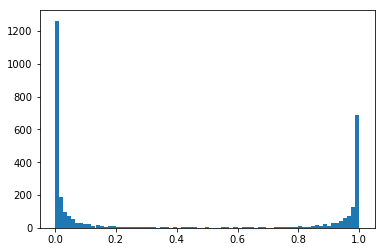

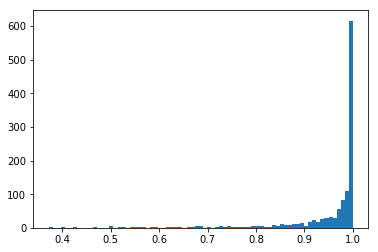

20

In [362]:
ppred = pd.DataFrame()
ppred['TrackNumber'] = train.TrackNumber
ppred['pred_y']      = pred_y_softmax
ppred['true_y']      = train.y

g0pred = ppred.groupby(['TrackNumber','pred_y']).size()
g1pred = ppred.groupby(ppred.TrackNumber).size(); #print(len(g1pred),g1pred.head())
temp   = np.round(g0pred/g1pred,6)
g0pred = g0pred.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
g0pred['pr'] = temp.values
print(g0pred.head())

g2pred = g0pred.reset_index()
g2pred = g2pred.pr.groupby(g2pred.TrackNumber).max()
plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g2pred,bins=75); plt.show()
#g0pred
g2pred.head()
len(g2pred[g2pred<0.60])

In [363]:
#Построение train-решения через probs без времени, только частотность

g100     = pd.DataFrame(pred_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6); 
g100pred.head()
if 1 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(30), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0      100047.0       0  0.924867
 1      100047.0       1  0.075133
 2      100070.0       1  0.562070
 3      100070.0       2  0.437930
 4      100080.0       0  0.079264
 5      100080.0       2  0.569298
 6      100080.0       3  0.351438
 7      100093.0       0  1.000000
 8      100144.0       0  0.814365
 9      100144.0       1  0.185635
 10     100161.0       0  0.603738
 11     100161.0       3  0.396262
 12     100175.0       0  0.844285
 13     100175.0       2  0.101912
 14     100175.0       3  0.053803
 15     100204.0       2  1.000000
 16     100216.0       0  0.172270
 17     100216.0       2  0.827730
 18     100262.0       0  1.000000
 19     100277.0       0  1.000000
 20     100287.0       0  1.000000
 21     100305.0       0  0.646263
 22     100305.0       2  0.353737
 23     100321.0       0  0.286106
 24     100321.0       2  0.713894
 25     100362.0       4  1.000000
 26     100370.0       2  0.136321
 27     100370.0    

In [364]:
g110     = pd.DataFrame(pred_y) # в работе время 
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(train.sTime+train.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 1 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype, g110pred.pr.max()

(    TrackNumber  pred_y        pr
 0      100047.0       0  0.929167
 1      100047.0       1  0.070833
 2      100070.0       1  0.737193
 3      100070.0       2  0.262807
 4      100080.0       0  0.069547
 5      100080.0       2  0.609789
 6      100080.0       3  0.320664
 7      100093.0       0  1.000000
 8      100144.0       0  0.765571
 9      100144.0       1  0.234429
 10     100161.0       0  0.322418
 11     100161.0       3  0.677582
 12     100175.0       0  0.829469
 13     100175.0       2  0.101230
 14     100175.0       3  0.069301
 15     100204.0       2  1.000000
 16     100216.0       0  0.177317
 17     100216.0       2  0.822683
 18     100262.0       0  1.000000
 19     100277.0       0  1.000000, dtype('int64'), 1.0)

In [365]:
ggtrain = pd.DataFrame(train[['TrackNumber','y']].groupby(['TrackNumber','y']).size().reset_index()); ggtrain.head()
ggtrain.columns   = ['TrackNumber','pred_y','size']
ggtrain['true_y'] = 1.0
ggtrain.head()

,TrackNumber,pred_y,size,true_y
0,100047,0,605,1.0
1,100070,1,379,1.0
2,100080,2,6528,1.0
3,100093,3,4781,1.0
4,100144,0,14972,1.0


In [366]:
#ggtrain  = ggtrain.reset_index()
#g100pred = g100pred.reset_index()
#gg.reset_index()

In [368]:
#ggtrain  = ggtrain.set_index(['TrackNumber','pred_y'])
#g100pred = g100pred.set_index(['TrackNumber','pred_y']) 
gg = pd.merge(g0pred.reset_index(),ggtrain,how='outer',suffixes=('_x','_y'),on=('TrackNumber','pred_y'))
gg = gg.drop('size',axis=1).fillna(0.0)
print(gg.head(15))
ggBad = gg[(gg.pr!=gg.true_y) & (gg.pr<0.50) & (gg.true_y>0.50)]['TrackNumber'].unique(); ggBad
##gg.set_index('TrackNumber')
ggBadTracks = gg.set_index('TrackNumber').loc[ggBad.tolist(),:].reset_index().TrackNumber.unique()
print len(ggBadTracks), ggBadTracks.tolist()
##gg.reset_index()
#ggtrain.pred_y.dtype
#g100pred.pred_y.dtype

    index  TrackNumber  pred_y        pr  true_y
0     0.0       100047       0  1.000000     1.0
1     1.0       100070       0  0.007916     0.0
2     2.0       100070       1  0.833773     1.0
3     3.0       100070       2  0.155673     0.0
4     4.0       100070       3  0.002639     0.0
5     5.0       100080       2  0.999387     1.0
6     6.0       100080       4  0.000613     0.0
7     7.0       100093       0  0.008157     0.0
8     8.0       100093       3  0.991843     1.0
9     9.0       100144       0  1.000000     1.0
10   10.0       100161       0  0.000363     0.0
11   11.0       100161       1  0.999637     1.0
12   12.0       100175       0  0.998392     1.0
13   13.0       100175       1  0.001608     0.0
14   14.0       100204       0  0.949504     1.0
11 [100362, 104192, 112290, 112859, 113817, 122298, 122635, 123632, 126567, 127152, 124127]


In [258]:
gg.head()
gg.set_index('TrackNumber').loc[124127,:]
#ggBad.tolist()
train[train.TrackNumber==124127].iloc[:,:] #range(7)+[9,10,11,12,13,14,16,17,18,19,20]]
train[train.TrackNumber==131933].iloc[:,range(4)+[5,8,9,11,12,13,14,16,17,18,19,20]]

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Latitude,Oceanic Depth,SOG,Sea Temperature,Speed,Thermocline Depth,Time,Water Surface Elevation,hTime,oceanic depth,sTime,y
7903028,131933,0.0965,-1369,89.524198,38.730267,-1369.0,0.8,13.4,1.042936,36.8,0,0.12,46.349167,NaN,166857.0,1
7903029,131933,0.1293,-1374,5.222915,39.257100,-1374.0,5.8,14.0,0.256474,21.2,166857,0.08,10.995833,NaN,39585.0,1
7903030,131933,0.1295,-1370,0.000000,39.248930,-1370.0,3.6,13.6,0.000000,15.7,206442,0.06,0.000278,NaN,1.0,1
7903031,131933,0.1295,-1370,33.307215,39.248930,-1370.0,3.6,13.6,0.733536,15.7,206443,0.06,24.517500,NaN,88263.0,1
7903032,131933,0.1256,-1368,0.000000,39.521087,-1368.0,5.3,14.5,0.000000,29.9,294706,0.04,0.000278,NaN,1.0,1
7903033,131933,0.1256,-1368,118.322964,39.521087,-1368.0,5.3,14.5,1.034872,29.9,294707,0.04,61.736389,NaN,222251.0,1
7903034,131933,0.1094,-1416,33.157381,38.457440,-1416.0,1.1,15.4,0.477881,26.9,516958,0.01,37.464444,NaN,134872.0,1
7903035,131933,0.1231,-1398,80.348455,38.734827,-1398.0,6.2,14.4,1.236716,32.7,651830,0.01,35.080556,NaN,126290.0,1
7903036,131933,0.1351,-1390,114.335794,39.175903,-1390.0,0.6,16.4,2.499140,122.1,778120,0.16,24.703056,NaN,88931.0,1
7903037,131933,0.1013,-1433,38.121725,38.151900,-1433.0,5.3,15.5,0.951743,69.7,867051,0.09,21.627778,NaN,77860.0,1


In [217]:
# Готовим решение по test

In [54]:
for ii,ffile in enumerate((test_list['trackfile'].values.tolist())): # [:10]) :
    xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
    xx['Time']  = xx[[1]]
    xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
    xx['hTime'] = xx.sTime/3600.0
    xx['Depth'] = xx[[5]]
    
    havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    
    cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)
    
    hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)
    
    xx['Distance'] = dist
    xx['Speed']    = (dist/1.852/xx.hTime).fillna(0.0)
    
    xx = xx.fillna(0.0)
    
    if (ii==0) : testAll = xx.copy()
    else : testAll = testAll.append(xx.copy())
        
print(testAll.shape)

(6586899, 20)


In [55]:
#testAll.to_csv('../Data/testingAll.csv',index=False)

In [382]:
testAll = pd.read_csv('../Data/testingAll.csv')

In [34]:
#testWeights = dataClean(testAll)

In [383]:
!ls -la ../Result
!ls -la ../Data
!ls -la ../Work
testAll.shape

total 77
drwxrwxrwx 1 boba boba  4096 сен  1 21:36 .
drwxrwxrwx 1 boba boba  4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba     0 сен  1 21:36 Best
-rwxrwxrwx 1 boba boba 66869 сен  3 15:25 bobaFish.csv
-rwxrwxrwx 1 boba boba   413 сен  1 16:53 FishingForFishermen2.java
drwxrwxrwx 1 boba boba     0 сен  1 16:36 .ipynb_checkpoints
total 2118448
drwxrwxrwx 1 boba boba       4096 сен  1 15:28 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks
total 54564
drwxrwxrwx 1 boba boba     4096 сен  3 02:49 .
drwxrwxrwx 1 boba boba     4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba        0 сен  3 02:09 .ipynb_checkpoints
-rwxrwxrwx 1 boba boba  9910843 сен  1 22:55 xgbModel.bst
-rwxrwxrwx 1 boba boba 10

(6586899, 20)

In [384]:
test_x = testAll.drop(['TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
mtest  = xgb.DMatrix(test_x)
test_x.shape

(6586899, 17)

In [385]:
test_y = xgbmodel.predict(mtest); ##pred_y[-20:],pred_y.max()

In [386]:
test_y_softmax = test_y.argmax(axis=1); test_y_softmax.shape

(6586899,)

In [387]:
test = testAll

In [388]:
if 0 :
    test_o           = test.copy()
    test_y_o         = test_y.copy()
    test_y_softmax_o = test_y_softmax.copy()
if 1 :
    test             = test_o.copy()
    test_y           = test_y_o.copy()
    test_y_softmax   = test_y_softmax_o.copy()
len(test), len(test_y), len(test_y_softmax)

(6586899, 6586899, 6586899)

In [389]:
test           = test[OKtest]
test_y         = test_y[OKtest]
test_y_softmax = test_y_softmax[OKtest]
len(test), len(test_y), len(test_y_softmax)

(5432594, 5432594, 5432594)

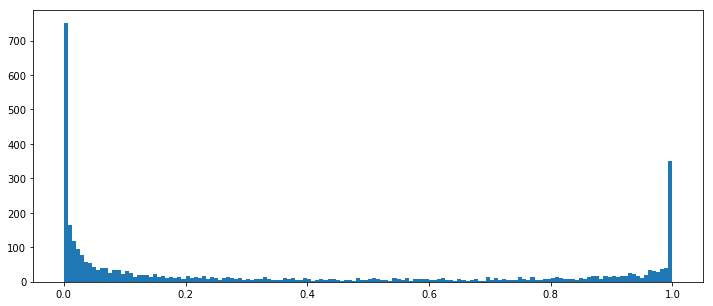

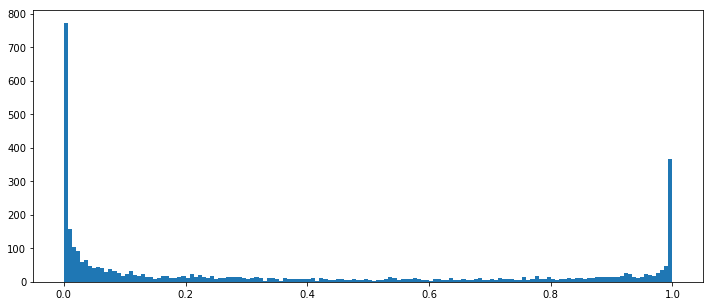

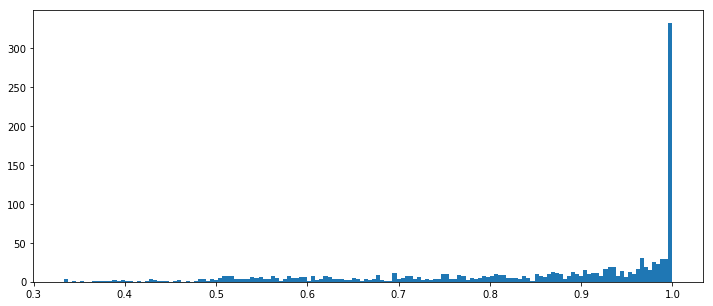

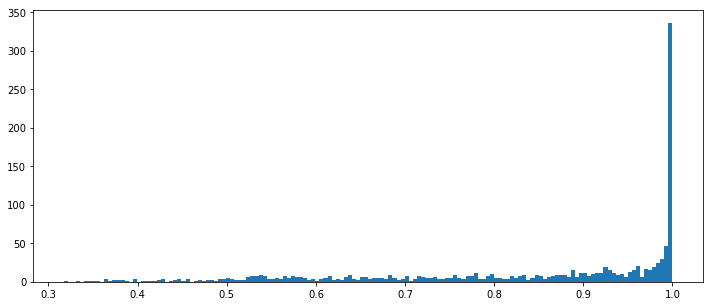

165 1e-06 1.0 0.0 1.0 2e-06 1.0


In [390]:
# Распределение результата test
ppred = pd.DataFrame()
ppred['TrackNumber'] = test.TrackNumber
ppred['pred_y'] = np.array(test_y_softmax,dtype=np.uint8)
##print(ppred.head())

tySize = ppred.groupby(['TrackNumber','pred_y']).size();
tSize  = ppred.groupby(['TrackNumber']).size();

g0pred = pd.DataFrame(np.round(tySize/tSize,4)).reset_index()   # common result table [Track#, pred#, prob]
g0pred.columns=['TrackNumber','pred_y','pr']

##print('Common result \n',g0pred.head())

ggmax, g4pred = [], g0pred.groupby('TrackNumber')

for tt in g0pred.TrackNumber.unique().tolist() :
    aa = g4pred.get_group(tt)
    ggmax.append(aa.pred_y[aa.pr.argmax()])

##print(len(ggmax),ggmax[:40])

g1pred = pd.DataFrame(g0pred.TrackNumber.unique())   # table only one max result for Track# [Track#, pred#, prob]
g1pred['pred_y'] = np.array(ggmax)
g1pred['pr']     = 1.0
g1pred.columns=['TrackNumber','pred_y','pr']

##print 'Only result pred = 1.0 \n',g1pred.head()

g2pred = ppred.copy()
g2pred['sTime']  = testAll.sTime
g2pred['sTimeX'] = testAll.sTime.shift()
g2pred = g2pred.fillna(0)

g2pred = g2pred.groupby(['TrackNumber','pred_y']).sum();
g2pred['ssTime'] = (g2pred.sTime+g2pred.sTimeX)*0.5
ttSize = g2pred.reset_index().groupby(['TrackNumber']).sum();
g2pred['prS']  = np.round(g2pred.sTime/ttSize.sTime,6)
g2pred['prX']  = np.round(g2pred.sTimeX/ttSize.sTimeX,6)
g2pred['prSX'] = np.round(g2pred.ssTime/ttSize.ssTime,6)
g2pred['pr']   = g2pred.prSX

##print g2pred.head(20)




g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#

plt.figure(figsize=(12,5)); plt.hist(g0pred.pr,bins=150); plt.show()
plt.figure(figsize=(12,5)); plt.hist(g2pred.prSX,bins=150); plt.show()

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()

print len(g3pred[g3pred<0.60]), g2pred.prS.min(), g2pred.prS.max(), g2pred.prX.min(), g2pred.prX.max(), g2pred.prSX.min(), g2pred.prSX.max()

In [391]:
#Построение решение через probs

g100     = pd.DataFrame(test_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);
if 1 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

g100pred.head(15)

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(20), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0      100015.0       0  0.076917
 1      100015.0       1  0.695514
 2      100015.0       2  0.227569
 3      100045.0       0  1.000000
 4      100060.0       0  0.397893
 5      100060.0       1  0.360745
 6      100060.0       2  0.241362
 7      100112.0       0  0.889375
 8      100112.0       1  0.110625
 9      100131.0       0  0.789677
 10     100131.0       1  0.091003
 11     100131.0       3  0.119320
 12     100150.0       1  0.655002
 13     100150.0       4  0.344998
 14     100151.0       0  0.379270
 15     100151.0       1  0.169667
 16     100151.0       2  0.118293
 17     100151.0       4  0.332770
 18     100215.0       1  0.241689
 19     100215.0       4  0.758311, dtype('int64'))

In [397]:
g110     = pd.DataFrame(test_y)
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(testAll.sTime+testAll.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 1 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0      100015.0       0  0.098532
 1      100015.0       1  0.743994
 2      100015.0       2  0.157474
 3      100045.0       0  1.000000
 4      100060.0       0  0.133880
 5      100060.0       1  0.505930
 6      100060.0       2  0.360190
 7      100112.0       0  1.000000
 8      100131.0       0  0.790099
 9      100131.0       1  0.081707
 10     100131.0       3  0.128194
 11     100150.0       1  0.588748
 12     100150.0       4  0.411252
 13     100151.0       0  0.349287
 14     100151.0       1  0.282810
 15     100151.0       2  0.107583
 16     100151.0       4  0.260320
 17     100215.0       1  0.313375
 18     100215.0       4  0.686625
 19     100221.0       1  0.241171, dtype('int64'))

In [396]:
#
# Построение решения из softProbs взвешенное временем до-после точки --> 874xxx
# 2 подход: -очистка, 200 раундов, отсутствие весов --> 880536.69
# 3 подход: --------  400 раундов --> 878101.38
# 4 подход: без взвешивания по времени, только среднее по точкам, 400 раундов --> 886230.54
# 5 подход: только softmax + выброс плохих точек, 400 раундов --> 885310.33
#
test_r = g110pred.copy()
test_r = g100pred.copy() # 4 step
test_r = g0pred.copy() # 5 step
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(20))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0285
1        100015   longliner  0.8327
2        100015      seiner  0.1388
3        100045     trawler  0.9998
4        100045      seiner  0.0002
5        100060     trawler  0.0492
6        100060   longliner  0.7203
7        100060      seiner  0.2300
8        100060     support  0.0006
9        100112     trawler  1.0000
10       100131     trawler  0.9611
11       100131   longliner  0.0014
12       100131       other  0.0375
13       100150   longliner  0.9439
14       100150      seiner  0.0530
15       100150     support  0.0032
16       100151     trawler  0.1217
17       100151   longliner  0.0082
18       100151      seiner  0.0341
19       100151     support  0.8359


In [84]:
g0pred.head()
test_r = g0pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(15))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0376
1        100015   longliner  0.8243
2        100015      seiner  0.1368
3        100015       other  0.0013
4        100045     trawler  1.0000
5        100060     trawler  0.0532
6        100060   longliner  0.7423
7        100060      seiner  0.2039
8        100060     support  0.0005
9        100112     trawler  1.0000
10       100131     trawler  0.8094
11       100131   longliner  0.0029
12       100131       other  0.1877
13       100150   longliner  0.9298
14       100150      seiner  0.0642


In [112]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (+-) вероятности типов судов
#  2017-09-02 +- хуже 886xxx -> 870xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prSX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.123381
1        100015   longliner  0.796768
2        100015      seiner  0.068208
3        100015       other  0.011644
4        100045     trawler  1.000000
5        100060     trawler  0.111688
6        100060   longliner  0.816666
7        100060      seiner  0.071583
8        100060     support  0.000063
9        100112     trawler  1.000000
10       100131     trawler  0.798129
11       100131   longliner  0.047469
12       100131       other  0.154402
13       100150   longliner  0.917904
14       100150      seiner  0.074431
15       100150     support  0.007665
16       100151     trawler  0.371117
17       100151   longliner  0.012507
18       100151      seiner  0.019218
19       100151     support  0.597159
20       100215     trawler  0.026426
21       100215   longliner  0.025318
22       100215      seiner  0.948256
23       100221     trawler  1.000000
24       100227     trawler  0.999765


In [113]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (- предыдущее время) вероятности типов судов
#  2017-09-02 - 870xxx->863xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.101394
1        100015   longliner  0.837527
2        100015      seiner  0.051816
3        100015       other  0.009262
4        100045     trawler  1.000000
5        100060     trawler  0.092662
6        100060   longliner  0.848095
7        100060      seiner  0.059195
8        100060     support  0.000048
9        100112     trawler  1.000000
10       100131     trawler  0.798759
11       100131   longliner  0.047166
12       100131       other  0.154074
13       100150   longliner  0.917502
14       100150      seiner  0.075145
15       100150     support  0.007353
16       100151     trawler  0.370181
17       100151   longliner  0.014386
18       100151      seiner  0.019686
19       100151     support  0.595747
20       100215     trawler  0.048802
21       100215   longliner  0.002205
22       100215      seiner  0.948993
23       100221     trawler  1.000000
24       100227     trawler  0.999768


In [373]:
#  2017-09-01 Почему-то дает провал на 511650.89 с 890501, хотя не должна?
# Only max predictions pr<-1.0
g1pred.head()
test_r = g1pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head())
##test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

   TrackNumber FishingType   pr
0       100015   longliner  1.0
1       100045     trawler  1.0
2       100060   longliner  1.0
3       100112     trawler  1.0
4       100131     trawler  1.0


In [42]:
##test_yy = xgbmodel.predict(mtest, pred_contribs=True)
xgb.__version__

'0.6'

In [273]:
xgbmodel.attributes()

{}

In [82]:
bbins = [aa for aa in range(49)] + [max(trainAll.hTime.max(),trainAll.hTime.max(),)+1.0]

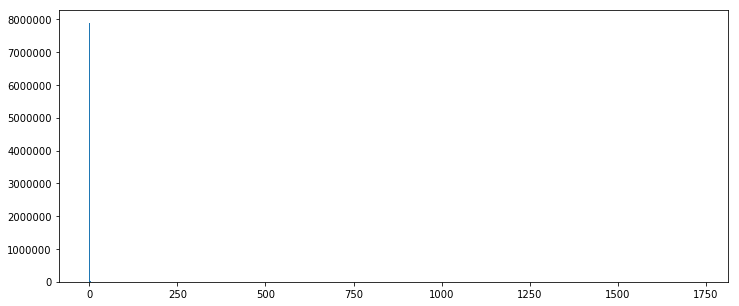

In [87]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(trainAll.hTime,bins=bbins); plt.show()

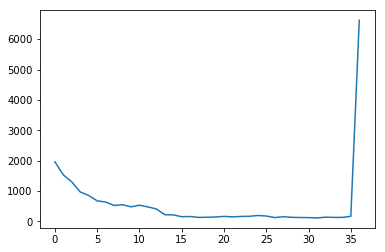

(50, 10596.0, array([  6.41767600e+06,   7.81920000e+04,   1.72610000e+04,
          1.02150000e+04,   7.46600000e+03,   6.46400000e+03,
          6.23000000e+03,   7.07300000e+03,   6.33900000e+03,
          4.01400000e+03,   2.76100000e+03,   2.11200000e+03,
          1.96100000e+03,   1.53100000e+03,   1.30000000e+03,
          9.69000000e+02,   8.53000000e+02,   6.78000000e+02,
          6.38000000e+02,   5.25000000e+02,   5.50000000e+02,
          4.81000000e+02,   5.35000000e+02,   4.78000000e+02,
          4.11000000e+02,   2.22000000e+02,   2.16000000e+02,
          1.55000000e+02,   1.63000000e+02,   1.33000000e+02,
          1.38000000e+02,   1.46000000e+02,   1.66000000e+02,
          1.51000000e+02,   1.64000000e+02,   1.69000000e+02,
          1.96000000e+02,   1.78000000e+02,   1.28000000e+02,
          1.56000000e+02,   1.35000000e+02,   1.30000000e+02,
          1.26000000e+02,   1.16000000e+02,   1.40000000e+02,
          1.33000000e+02,   1.33000000e+02,   1.69000000e

In [96]:
plt.plot(hh[12:]); plt.show()
len(bb), hh[24:].sum(), hh, bb

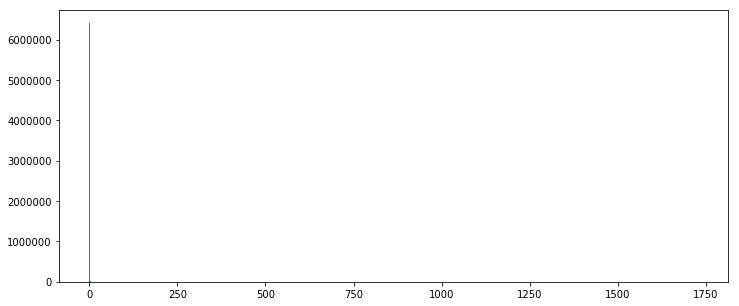

In [95]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(testAll.hTime,bins=bbins); plt.show()

In [369]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((trainAll.hTime<=hTimeMax) & (trainAll.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)
OKtest  = ((testAll.hTime<=hTimeMax) & (testAll.hTime>hTimeMin))
NOtest  = np.logical_not(OKtest)


print('All tracks: \ttrain={}, test={}\nTracks with wrong records:  \ttrain={}, test={}\nTracks with good records:  \ttrain={}, test={}'. \
          format(len(trainAll.TrackNumber.unique()),len(testAll.TrackNumber.unique()), \
                 len(trainAll.TrackNumber[NOtrain].unique()), \
                 len(testAll.TrackNumber[NOtest].unique()), \
                 len(trainAll.TrackNumber[OKtrain].unique()), \
                 len(testAll.TrackNumber[OKtest].unique())))

All tracks: 	train=1209, test=1211
Tracks with wrong records:  	train=1209, test=1211
Tracks with good records:  	train=1209, test=1211


In [157]:
print('train={}, test={}'.format(len(trainAll.TrackNumber[((trainAll.hTime>hTimeMax) | (trainAll.hTime<hTimeMin))]),
                                 len(testAll.TrackNumber[((testAll.hTime>hTimeMax) | (testAll.hTime<hTimeMin))] ) ))

train=938990, test=658466


In [133]:
train[train.hTime> 48.0]

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
69,100047,0.3114,-4,0.635781,-0.04,41.099857,1.232748,-0.03,NaN,8.9,...,10.6,0.005562,113.6,210835,210835,-0.21,61.726111,-4.0,222214.0,0
93,100047,0.3095,-5,0.905187,-0.21,41.107890,1.238818,-0.10,NaN,0.0,...,10.2,0.004476,123.8,643825,643825,-0.19,109.190278,-5.0,393085.0,0
179,100047,0.3043,-10,3.923416,-0.04,41.078055,1.213548,0.01,NaN,10.6,...,9.9,0.034441,263.1,1420301,1420301,-0.17,61.510556,-10.0,221438.0,0
251,100047,0.3043,-10,2.912001,0.10,41.082810,1.215468,0.04,NaN,10.7,...,9.8,0.025526,323.8,2024705,2024705,-0.21,61.597778,-10.0,221752.0,0
297,100047,0.3092,-5,3.436802,0.05,41.104813,1.239307,0.11,NaN,0.5,...,9.6,0.029979,157.6,2629425,2629425,-0.29,61.900000,-5.0,222840.0,0
359,100047,0.2080,-4,2.703458,-0.06,41.088820,1.221198,0.05,NaN,9.4,...,9.6,0.023528,252.4,3232398,3232398,-0.30,62.043333,-4.0,223356.0,0
418,100047,0.2047,-5,0.207280,-0.12,41.108707,1.240357,0.29,NaN,0.0,...,9.6,0.001338,380.1,3759683,3759683,-0.23,83.626111,-5.0,301054.0,0
453,100047,0.2042,-5,2.327180,-0.12,41.104318,1.241150,0.17,NaN,0.8,...,9.7,0.020191,184.3,4442169,4442169,-0.24,62.235278,-5.0,224047.0,0
473,100047,0.2092,-3,0.086283,0.00,41.083383,1.215767,0.10,NaN,7.3,...,9.9,0.000745,252.4,5046051,5046051,-0.25,62.506389,-3.0,225023.0,0
495,100047,0.1735,-5,3.308095,-0.02,41.105027,1.242002,0.18,NaN,8.4,...,9.8,0.028623,229.6,5651446,5651446,-0.26,62.406389,-5.0,224663.0,0
